# ________________________________________
# Tarefa 4 - Implementação de um MLPKerasClassifier com as mesmas funções do exercício 3
# ________________________________________

Implemente utilizando a API do scikit-learn um MLP para classificação usando Keras.

A implementação deve lidar dataset binários e multiclasse sem a necessidade de enviar parâmetros indicando qual o tipo da base.

A quantidade de neurônios nas camadas intemediárias e a função de ativação usada nelas deve poder ser passada pelo construtor.

In [3]:
import numpy as np
import pandas as pd
import sklearn as sklearn
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator,ClassifierMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import random
import gc

#import tensorflow as tf
#from tensorflow import keras
#from tensorflow.keras import layers


DEBUG = 'DEBUG'

np.__version__,pd.__version__,sklearn.__version__

('1.22.3', '1.4.2', '1.0.2')

In [4]:
import tensorflow as tf
from tensorflow import keras
import gc

from tensorflow.keras import Sequential, layers, losses
from tensorflow.keras.models import Model
#from tensorflow.keras.datasets import fashion_mnist
from tqdm.keras import TqdmCallback

DEBUG = 'DEBUG: '

tf.keras.backend.clear_session()
gc.collect()

def disable_gpu_tf():
  try:
      # Disable all GPUS
      tf.config.set_visible_devices([], 'GPU')
      visible_devices = tf.config.get_visible_devices()
      for device in visible_devices:
        print(DEBUG,visible_devices)
        assert device.device_type != 'GPU'
  except:
      # Invalid device or cannot modify virtual devices once initialized.
      pass

print(DEBUG,tf.__version__)
print(DEBUG,tf.config.get_visible_devices())
disable_gpu_tf()

d:\ProgramData\Miniconda3\envs\ppcompts\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DEBUG:  2.6.0
DEBUG:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
DEBUG:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [5]:
def criaDataset(n=20,slop=[2,1],intercept=-0.4):
  X = np.random.uniform(size=(n,2))
  AUX = np.multiply(X,slop) - [0,intercept]
  y = (AUX[:,0] > AUX[:,1])*2 -1
  return X,y

def criaDatasetBlobs(n=1000,n_classes=4,std=0.02):
  X,y = make_blobs(n_samples=n,centers=n_classes,center_box=(0,1.0),cluster_std=0.02)
  return X,y

def criaDatasetXOR(n=100):
  X,y = make_blobs(n_samples=n,centers=[[0,0],[1,0],[1,1],[0,1]],cluster_std=0.1)
  y =np.array(y%2,dtype=int)
  return X,y

def criaDatasetNBlobsXOR(n=1000,n_classes=3,std=0.8):
  X,y = make_blobs(n_samples=n,centers=n_classes*2,cluster_std=std)
  y = np.array(y%n_classes,dtype=int)
  return X,y

def plotDataset(X,y):
  plt.xlabel('X1')
  plt.ylabel('X2')
  for k in set(y):
    plt.plot(X[:,0][y==k],
             X[:,1][y==k],
             "o",alpha=0.3)

In [6]:
def define_axes(X,margin=0.1):
  min1,max1 = X[:,0].min(), X[:,0].max()
  min2,max2 = X[:,1].min(), X[:,1].max()
  return [min1 -margin, max1 +margin,min2 -margin,max2 +margin]

    

def plotPredictions(clf,X,y=None,dims=[0,1]):
  axes = define_axes(X)
  x0s = np.linspace(axes[0],axes[1],100)
  x1s = np.linspace(axes[2],axes[3],100)
  x0,x1 = np.meshgrid(x0s,x1s)
  X_ = np.c_[x0.ravel(),x1.ravel()]
  #print(DEBUG,X_.shape)
  yp = clf.predict(X)
  ypred = clf.predict(X_).reshape(x0.shape)
  if y is not None: print(sum(yp==y)/len(y))
  #print(DEBUG,X_.shape,x0.shape,x1.shape,ypred.shape)
  plt.contourf(x0,x1,ypred,cmap=plt.cm.brg,alpha=0.2)

In [26]:
tf.keras.backend.clear_session()
gc.collect()

class MLPKerasClassifier(BaseEstimator,ClassifierMixin):
  def __init__(self,max_iter=1000,n_hidden=[5,4],hidden_activation='relu',batch_size=None
              ,optimizer=tf.keras.optimizers.Adam,learning_rate=0.001
              ,es_patience=20,es_monitor='val_loss',validation_split=0.2
              ,use_multiprocessing =True
              ):
    self.max_iter = max_iter
    self.n_hidden = n_hidden
    self.batch_size = batch_size 
    self.hidden_activation = hidden_activation
    self.learning_rate = learning_rate
    self.opt = optimizer(learning_rate=learning_rate)
    self.validation_split = validation_split
    self.es_patience = es_patience
    self.es_monitor = es_monitor
    self.use_multiprocessing = use_multiprocessing
    self.history_ = {}
    self.es = tf.keras.callbacks.EarlyStopping(
                              monitor=es_monitor,
                              min_delta=0,
                              patience=es_patience,
                              verbose=0,
                              mode='auto',
                              restore_best_weights=True
                          )

  def fit(self,X,y):
    self.labels,ids = np.unique(y,return_inverse=True)
    yhot = tf.keras.utils.to_categorical(ids)
    self.model = tf.keras.models.Sequential()
    self.model.add(tf.keras.layers.InputLayer(input_shape=(X.shape[1],)))
    
    if self.n_hidden:
      for i,h in enumerate(self.n_hidden):
        #print(DEBUG,i,h)
        self.model.add(tf.keras.layers.Dense(h))
        if i<len(self.n_hidden)-1:
          self.model.add(tf.keras.layers.Activation(self.hidden_activation))

      self.model.add(tf.keras.layers.Activation(self.hidden_activation))
    self.model.add(tf.keras.layers.Dense(yhot.shape[1],name='last_layer'))
    self.model.add(tf.keras.layers.Activation('softmax',name='softmax'))    
    self.model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer=self.opt)
    new_history = self.model.fit(X,yhot,batch_size=self.batch_size,epochs=self.max_iter,verbose=0
                      ,validation_split=self.validation_split,callbacks=[self.es,TqdmCallback()]
                      ,use_multiprocessing = self.use_multiprocessing)
    self.history_ = self.appendHist(self.history_,new_history.history)
    self.coef_ = self.model.get_weights()
  
  def predict(self,X):
    predictions = self.model.predict(X)
    return self.labels[np.argmax(predictions,axis=1)]
  
  def summary(self):
    self.model.summary()
    print(self.model.get_weights()[0])
    print(self.model.get_weights()[1])
    self.plotHistory()
  
  def plotHistory(self,yscale='linear',bfilter=2):
      plt.plot(self.history_["loss"][bfilter:], label="Training Loss")
      plt.yscale(yscale)
      try: 
        plt.plot(self.history_["val_loss"][bfilter:], label="Validation Loss")
        plt.yscale(yscale)
      except: pass
      plt.legend()
      plt.show()

  def appendHist(self, h1, h2):
    if h1 == {}:
        return h2
    else:
        dest = {}
        for key, value in h1.items():
            dest[key] = value + h2[key]
        return dest

100%|██████████| 1000/1000 [00:04<00:00, 244.62epoch/s, loss=0.68, accuracy=0.5]


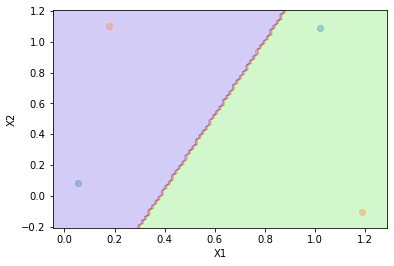

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
last_layer (Dense)           (None, 2)                 6         
_________________________________________________________________
softmax (Activation)         (None, 2)                 0         
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________
[[ 0.2977389   0.8560203 ]
 [-0.65692353 -0.8886552 ]]
[ 0.10669075 -0.10669128]


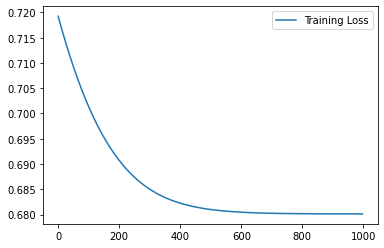

In [27]:
Xtr,ytr = criaDatasetXOR(4)
clf = MLPKerasClassifier(n_hidden=None,hidden_activation='linear',es_patience=100,validation_split=None,es_monitor='loss')
clf.fit(Xtr,ytr)


plotDataset(Xtr,ytr)
plotPredictions(clf,Xtr)
plt.show()
clf.summary()

 56%|█████▋    | 564/1000 [00:02<00:01, 228.80epoch/s, loss=0.692, accuracy=0.5] 


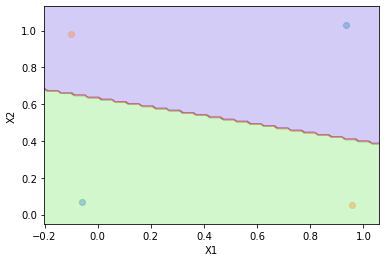

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4)                 12        
_________________________________________________________________
activation (Activation)      (None, 4)                 0         
_________________________________________________________________
last_layer (Dense)           (None, 2)                 10        
_________________________________________________________________
softmax (Activation)         (None, 2)                 0         
Total params: 22
Trainable params: 22
Non-trainable params: 0
_________________________________________________________________
[[ 0.4811642   0.5325893   0.9129271  -0.6785772 ]
 [-0.7904475  -0.98044485  0.5029577   0.68368953]]
[-0.01469318  0.01934092 -0.00144558  0.03973245]


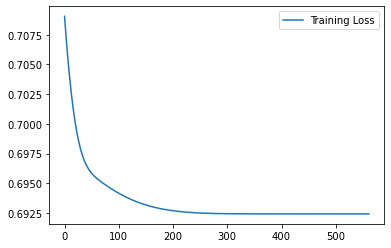

In [28]:
Xtr,ytr = criaDatasetXOR(4)
clf = MLPKerasClassifier(n_hidden=[4],hidden_activation='linear',es_patience=100,validation_split=None,es_monitor='loss')
clf.fit(Xtr,ytr)


plotDataset(Xtr,ytr)
plotPredictions(clf,Xtr)
plt.show()
clf.summary()

100%|██████████| 1000/1000 [00:04<00:00, 238.27epoch/s, loss=0.148, accuracy=1]  


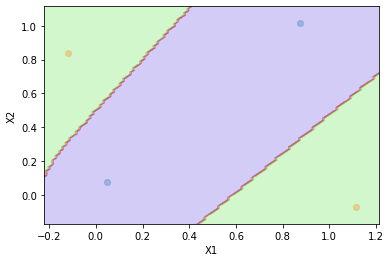

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 5)                 15        
_________________________________________________________________
activation_1 (Activation)    (None, 5)                 0         
_________________________________________________________________
last_layer (Dense)           (None, 2)                 12        
_________________________________________________________________
softmax (Activation)         (None, 2)                 0         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
[[-0.46901354  0.79044014 -1.966281    2.188496   -0.6707145 ]
 [-0.78850406  0.22283429  1.5865445  -1.5294229  -0.3418185 ]]
[ 0.          0.44939497 -0.02760798 -0.3360682   0.        ]


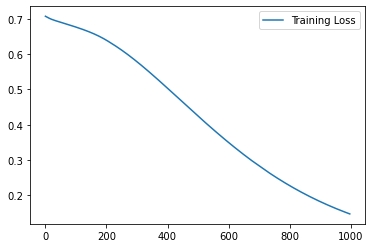

In [29]:
Xtr,ytr = criaDatasetXOR(4)
clf = MLPKerasClassifier(n_hidden=[5],hidden_activation='relu',es_patience=100,validation_split=None,es_monitor='loss')
clf.fit(Xtr,ytr)


plotDataset(Xtr,ytr)
plotPredictions(clf,Xtr)
plt.show()
clf.summary()

100%|██████████| 100/100 [00:02<00:00, 35.73epoch/s, loss=0.00954, accuracy=1, val_loss=0.01, val_accuracy=1]    


1.0


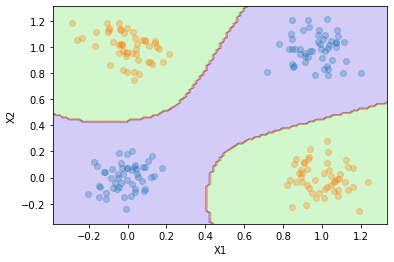

100%|██████████| 100/100 [00:02<00:00, 35.79epoch/s, loss=0.18, accuracy=1, val_loss=0.185, val_accuracy=1]       


1.0


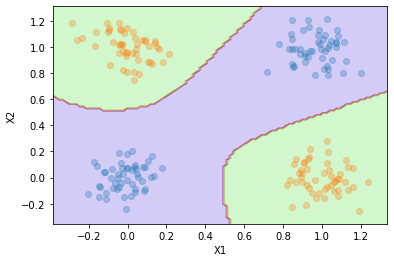

100%|██████████| 100/100 [00:02<00:00, 35.07epoch/s, loss=0.0177, accuracy=1, val_loss=0.0176, val_accuracy=1]     


1.0


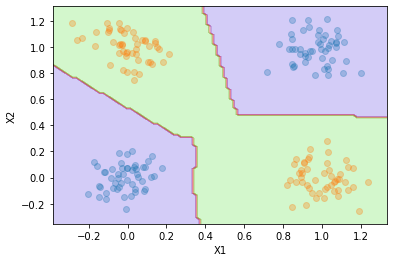

CPU times: total: 12.1 s
Wall time: 9.75 s


In [31]:
%%time
Xtr,ytr = criaDatasetXOR(200)
activation_list = ['tanh','sigmoid','relu']
for act in activation_list:
  clf = MLPKerasClassifier(n_hidden=[5],hidden_activation=act,learning_rate=0.01,max_iter=100)
  clf.fit(Xtr,ytr)

  #plotPredictions(clf,Xtr)
  #plt.show()

  #Xte,yte = criaDatasetNBlobsXOR(10000)
  #plotDataset(Xte,yte)
  plotDataset(Xtr,ytr)
  plotPredictions(clf,Xtr,ytr)
  plt.show()

 30%|██▉       | 296/1000 [00:07<00:18, 38.53epoch/s, loss=0.0996, accuracy=0.969, val_loss=0.216, val_accuracy=0.9] 


0.955


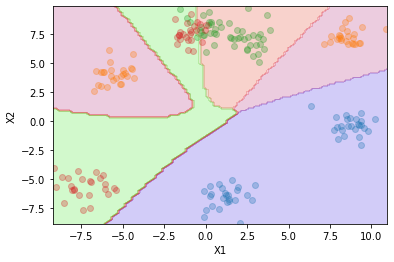

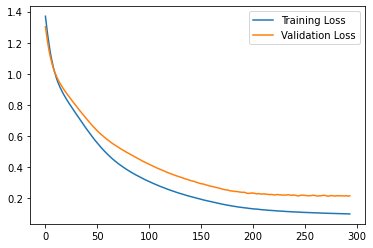

 86%|████████▌ | 855/1000 [00:21<00:03, 40.23epoch/s, loss=0.106, accuracy=0.975, val_loss=0.213, val_accuracy=0.9]  


0.96


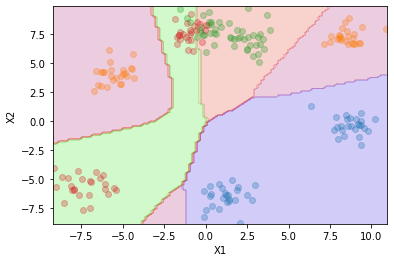

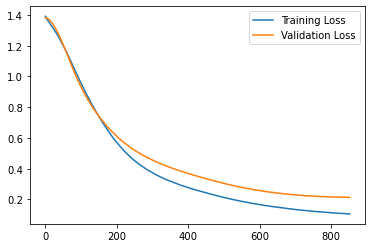

 44%|████▍     | 443/1000 [00:11<00:14, 39.29epoch/s, loss=0.111, accuracy=0.969, val_loss=0.296, val_accuracy=0.9]  


0.955


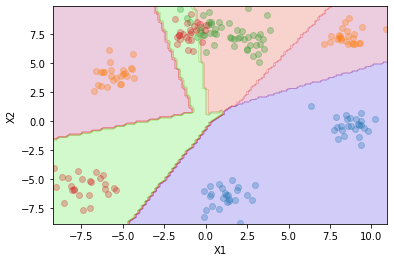

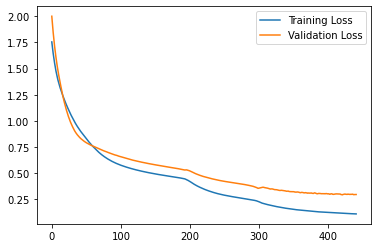

CPU times: total: 54.8 s
Wall time: 41.7 s


In [44]:
%%time
Xtr,ytr = criaDatasetNBlobsXOR(200,n_classes=4)
activation_list = ['tanh','sigmoid','relu']
for act in activation_list:
  clf = MLPKerasClassifier(n_hidden=[12,6],hidden_activation=act,learning_rate=0.001,max_iter=1000)
  clf.fit(Xtr,ytr)

  #plotPredictions(clf,Xtr)
  #plt.show()

  #Xte,yte = criaDatasetNBlobsXOR(10000)
  #plotDataset(Xte,yte)
  plotDataset(Xtr,ytr)
  plotPredictions(clf,Xtr,ytr)
  plt.show()
  clf.plotHistory()

0.95


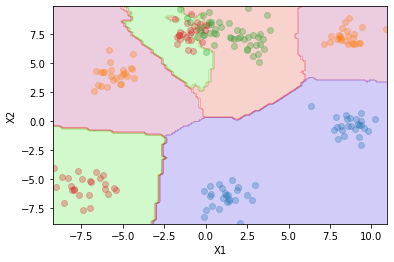

In [45]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(Xtr,ytr)


plotDataset(Xtr,ytr)
plotPredictions(clf,Xtr,ytr)